In [1]:
#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.feature_extraction.text
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn import preprocessing, linear_model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.datasets import fetch_20newsgroups, make_blobs
from sklearn.feature_extraction.text import TfidfVectorizer  #Feature extraction
from sklearn.naive_bayes import MultinomialNB #Our learner.
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import neighbors
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, SelectFromModel
import pandas as pd

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
from matplotlib.colors import ListedColormap
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

%matplotlib inline

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

/home/juliazhou/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pandas.read_pickle('cmv_full_features.pkl')
#df = df.sample(frac = .1)
#splitting data
data_train, data_test = train_test_split(df, test_size=0.3, random_state=123)
data_train['is_train'] = True
data_test['is_train'] = False

/home/juliazhou/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/juliazhou/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
#turn the training dataset into a tf-idf matrix
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_features = 10000, ngram_range=(1, 10),stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(data_train['com_text'])
TFVects.shape #(3836, 32241)
#print(TFVects.shape

(26852, 10000)

In [4]:
#Perform SVD on this matrix to reduce dimensionality

# SVD = TruncatedSVD(n_components=1000, random_state=123)
# reduced_data = SVD.fit_transform(TFVects)
# reduced_data.shape

In [5]:
#combining tfidf features with liguistic features and clustering labels
tfdf = pd.DataFrame(TFVects.toarray())
features_train = pd.concat([tfdf, data_train.reset_index()[['index', 'com_upvotes', 'KL', 'JS', 'kmeans', 'com_avg_pt_depth']]], axis = 1, ignore_index = False)
features_train.set_index('index', inplace = True)

In [6]:
#turn the test dataset into a tf-idf
TFVects_test = TFVectorizer.transform(data_test['com_text'])
#reduced_test = SVD.transform(TFVects_test)
tfdf_test = pd.DataFrame(TFVects_test.toarray())
features_test = pd.concat([tfdf_test, data_test.reset_index()[['index', 'com_upvotes', 'KL', 'JS', 'kmeans', 'com_avg_pt_depth']]], axis = 1, ignore_index = False)
features_test.set_index('index', inplace = True)

In [63]:
X = features_train
y = data_train['com_delta_received'].as_matrix()

In [64]:
X_test = features_test
y_test = data_test['com_delta_received'].as_matrix()

# Feature extraction

Idea: We realized that none of the implementations of the machine learning algorithms actually provides us with the list of features that are most reliable to classify comments. Thus, we are using feature extraction tools from sklearn.

Oh, we've observed that the features are very stable across algorithms, we could interpret these features by finding them in comments and see if these comments receive delta or not

## feature extraction using SelectKBest

In [24]:
def extract_KBest(func, k):
    selector = SelectKBest(func, k=k).fit(X,y)
    feature_indices = selector.get_support(indices=True)
    
    selected_features = features_train.columns[feature_indices].get_values()
    scores = selector.scores_[feature_indices]
    if selector.pvalues_ != None:
        pvalues = selector.pvalues_[feature_indices]
    else:
        pvalues = None
    return (selected_features, scores, pvalues)

In [25]:
#f_classif
selected_features_f, scores_f, pvalues_f = extract_KBest(sklearn.feature_selection.f_classif, 20)
selected_features_f

/home/juliazhou/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


array([187, 253, 376, 695, 1857, 2139, 2158, 3290, 3385, 3583, 4271, 4850,
       5531, 6113, 6121, 7440, 'com_upvotes', 'KL', 'JS',
       'com_avg_pt_depth'], dtype=object)

In [37]:
tf_features_indices_f = selected_features_f[:-4].astype(int)
all_features_f  = np.array(TFVectorizer.get_feature_names())[tf_features_indices_f].tolist()
all_features_f.extend(selected_features_f[-4:])
#all_features_f
d = {'all_features_f': all_features_f, 'scores_f': scores_f, 'pvalues_f': pvalues_f}
F_f_DF = pd.DataFrame(data = d).sort(columns='scores_f', axis=0, ascending=False).reset_index(drop = True)
F_f_DF

/home/juliazhou/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,all_features_f,pvalues_f,scores_f
0,com_upvotes,0.000000e+00,2598.615876
1,large group,1.635654e-13,54.456131
2,JS,2.971789e-13,53.280571
3,KL,3.674229e-13,52.862969
4,outrage,4.733387e-13,52.364524
5,mexican,8.204640e-13,51.282426
6,outcomes,1.344589e-10,41.275076
7,audiences,2.990624e-10,39.710802
8,airline,5.830431e-10,38.405535
9,accountable,1.000888e-09,37.349810


In [31]:
#chi2 - we can't use this algo because some values of upvotes are negative


In [39]:
#mutual_info_classif
selected_features_m, scores_m, pvalues_m = extract_KBest(mutual_info_classif, 20)
selected_features_m

array([405, 1634, 2488, 2560, 3980, 4665, 5072, 5095, 5191, 5268, 5803,
       6632, 6717, 6815, 8881, 9012, 9294, 9913, 'com_upvotes',
       'com_avg_pt_depth'], dtype=object)

In [40]:
pvalues_m

In [42]:
tf_features_indices_m = selected_features_m[:-2].astype(int)
all_features_m  = np.array(TFVectorizer.get_feature_names())[tf_features_indices_m].tolist()
all_features_m.extend(selected_features_m[-2:])
#all_features_m
d = {'all_features_m': all_features_m, 'scores_m': scores_m}
F_m_DF = pd.DataFrame(data = d).sort(columns='scores_m', axis=0, ascending=False).reset_index(drop = True)
F_m_DF

/home/juliazhou/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,all_features_m,scores_m
0,com_upvotes,0.029531
1,things,0.004259
2,just,0.004141
3,does,0.003941
4,point,0.003561
5,com_avg_pt_depth,0.003424
6,need,0.003190
7,pretty,0.003175
8,make,0.003133
9,time,0.003096


In [ ]:
F_m_DF

## Feature extraction using Tree-based feature selection

In [43]:
def extract_model(clf_fitted):
    feature_indices = SelectFromModel(clf_fitted, prefit=True).get_support(indices=True)
    try:
        score = clf_fitted.feature_importances_[feature_indices]
    except:
        score = None
    selected_features = features_train.columns[feature_indices].get_values()
    return (selected_features, score)

In [44]:
#Decision tree
tree_clf = DecisionTreeClassifier(max_depth=10,random_state=0).fit(X, y)

In [45]:
selected_features_t1, scores_t1 = extract_model(tree_clf)
selected_features_t1

array([129, 200, 253, 347, 377, 460, 463, 481, 529, 1176, 1857, 2118, 2348,
       2459, 2491, 2560, 2601, 2658, 3085, 3122, 3435, 3594, 3598, 3661,
       3754, 3892, 3961, 4665, 4890, 5022, 5446, 5596, 5748, 6121, 6298,
       6596, 6704, 6926, 6957, 7376, 7509, 7701, 7976, 7992, 8077, 8100,
       8170, 8255, 8536, 8825, 8828, 8859, 8881, 8904, 9453, 9684, 9731,
       9872, 9917, 9962, 'com_upvotes'], dtype=object)

In [46]:
selected_features_t1.shape

(61,)

In [47]:
tf_features_indices_t1 = selected_features_t1[:-2].astype(int)
all_features_t1  = np.array(TFVectorizer.get_feature_names())[tf_features_indices_t1].tolist()
all_features_t1.extend(selected_features_t1[-2:])
#all_features_t1

d = {'all_features_t1': all_features_t1, 'scores_t1': scores_t1}
F_t1_DF = pd.DataFrame(data = d).sort(columns='scores_t1', axis=0, ascending=False).reset_index(drop = True)
F_t1_DF.iloc[:20, :]

/home/juliazhou/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,all_features_t1,scores_t1
0,com_upvotes,0.400377
1,sold,0.025940
2,additional,0.019782
3,theoretically,0.018814
4,extra,0.017462
5,difficult,0.017413
6,giving,0.017193
7,annoying,0.016848
8,airlines,0.016255
9,animal,0.016221


In [48]:
#Extra decision tree
#fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset 
#and use averaging to improve the predictive accuracy and control over-fitting
tree2_clf = ExtraTreesClassifier(n_estimators=250,random_state=0).fit(X, y)

In [49]:
selected_features_t2, scores_t2 = extract_model(tree2_clf)
#selected_features_t2[2700:]

In [50]:
#selected_features_t2[2600:]

In [51]:
tf_features_indices_t2 = selected_features_t2[:-5].astype(int)
all_features_t2  = np.array(TFVectorizer.get_feature_names())[tf_features_indices_t2].tolist()
all_features_t2.extend(selected_features_t2[-5:])
#all_features_t1

d = {'all_features_t2': all_features_t2, 'scores_t2': scores_t2}
F_t2_DF = pd.DataFrame(data = d).sort(columns='scores_t2', axis=0, ascending=False).reset_index(drop = True)
F_t2_DF.iloc[:20, :]

/home/juliazhou/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,all_features_t2,scores_t2
0,com_upvotes,0.019197
1,com_avg_pt_depth,0.002823
2,KL,0.002605
3,JS,0.002588
4,kmeans,0.002266
5,think,0.001842
6,people,0.001700
7,just,0.001634
8,don,0.001416
9,like,0.001358


In [52]:
F_DF = pd.concat([F_f_DF, F_m_DF, F_t1_DF.iloc[:20, :], F_t2_DF.iloc[:20, :]], axis =1)
F_DF

,all_features_f,pvalues_f,scores_f,all_features_m,scores_m,all_features_t1,scores_t1,all_features_t2,scores_t2
0,com_upvotes,0.000000e+00,2598.615876,com_upvotes,0.029531,com_upvotes,0.400377,com_upvotes,0.019197
1,large group,1.635654e-13,54.456131,things,0.004259,sold,0.025940,com_avg_pt_depth,0.002823
2,JS,2.971789e-13,53.280571,just,0.004141,additional,0.019782,KL,0.002605
3,KL,3.674229e-13,52.862969,does,0.003941,theoretically,0.018814,JS,0.002588
4,outrage,4.733387e-13,52.364524,point,0.003561,extra,0.017462,kmeans,0.002266
5,mexican,8.204640e-13,51.282426,com_avg_pt_depth,0.003424,difficult,0.017413,think,0.001842
6,outcomes,1.344589e-10,41.275076,need,0.003190,giving,0.017193,people,0.001700
7,audiences,2.990624e-10,39.710802,pretty,0.003175,annoying,0.016848,just,0.001634
8,airline,5.830431e-10,38.405535,make,0.003133,airlines,0.016255,don,0.001416
9,accountable,1.000888e-09,37.349810,time,0.003096,animal,0.016221,like,0.001358


In [60]:
F_DF.to_pickle('extracted_features.pkl')

## Unfortunately, we cannot directly interpret the first two metrics we used for feature extraction. Let's see how the ensembling tree classifier work on the test set.

In [65]:
pred = tree2_clf.predict(X_test)

NameError: name 'savefig' is not defined

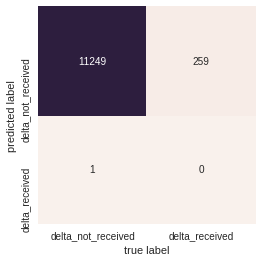

In [74]:
mat = confusion_matrix(y_test, pred)
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['delta_not_received', 'delta_received'], yticklabels=['delta_not_received', 'delta_received'])
plt.xlabel('true label')
plt.ylabel('predicted label');
#savefig('cf_ensemble.png', bbox_inches="tight")

In [69]:
print('Precision: {}'.format(sklearn.metrics.precision_score(y_test, pred, average = 'weighted'))) 
print('Recall: {}'.format(sklearn.metrics.recall_score(y_test, pred, average = 'weighted'))) 
print('F1 Score: {}'.format(sklearn.metrics.f1_score(y_test, pred, average = 'weighted'))) 

Precision: 0.9554962698186693
Recall: 0.9774089842731775
F1 Score: 0.966328418408757


In [70]:
#labels = [1 if dr else 0 for dr in labels]
probs = tree2_clf.predict_proba(X_test)
print('AUC Score: {}'.format(sklearn.metrics.roc_auc_score(y_test, probs[:,1])))

AUC Score: 0.7890848562848563


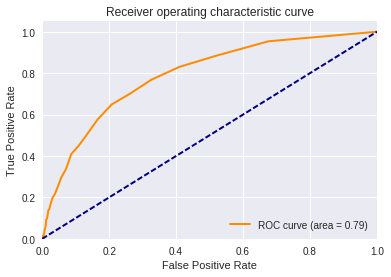

NameError: name 'savefig' is not defined

In [72]:
#ROC curve
x, y, _ = sklearn.metrics.roc_curve(y_test, probs[:,1])
roc_auc = sklearn.metrics.auc(x,y)

plt.figure()
plt.plot(x,y, color = 'darkorange', lw = 2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()
#savefig('ROC_ensemble.png', bbox_inches='tight')